In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression as LR

import xgboost as xgb

# EDA

## Первичный анализ

In [2]:
train = pd.read_csv('train.csv', index_col='Id')
test = pd.read_csv('test.csv', index_col='Id')

print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (1460, 80)
Test shape: (1459, 79)


У нас достоточно много признаков, но не очень много данных.

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Очень много признаков, боловина признаков -категориальные, на некоторых признаков практически нет данных

Посмотрим на корреляцию между признаками:

<AxesSubplot:>

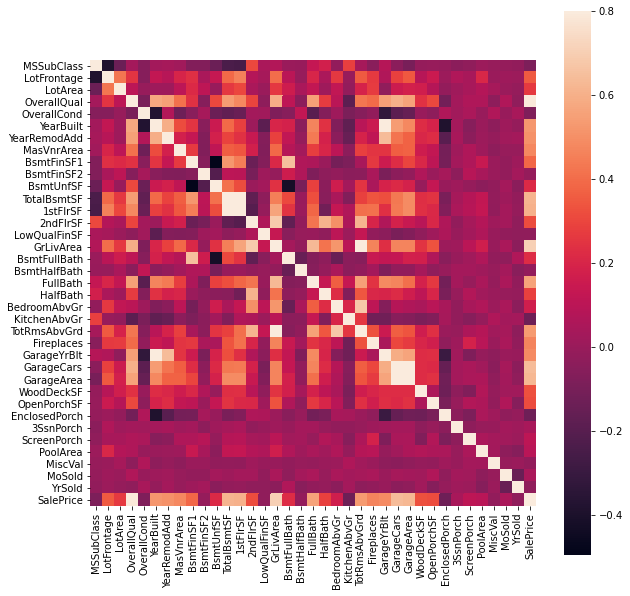

In [9]:
corr_matrix = train.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, vmax=.8, square=True)

У нас есть несколько зависимых друг от друга переменных, которые нужно будет исключить:
1. GarageYrBlt(Year garage was built) и yearBuilt. Можно убрать GarageYrBlt, он не так важен
2. TotRmsAbvGrd(Total rooms above grade) и GrLivArea (Above grade living area square feet). Можно оставить количество комнат
3. 1stFlrSF(First Floor square feet) и TotalBsmtSF(Total square feet of basement area)
4. GarageArea и GarageCars. Можно оставить количество машин

SalePrice хорошо коррелирует с OverallQual, GrLivArea, TotalBsmtSF(Total square feet of basement area), 1stFlrSF, GarageCars

Посмотрим на корреляции поподробнее

<AxesSubplot:>

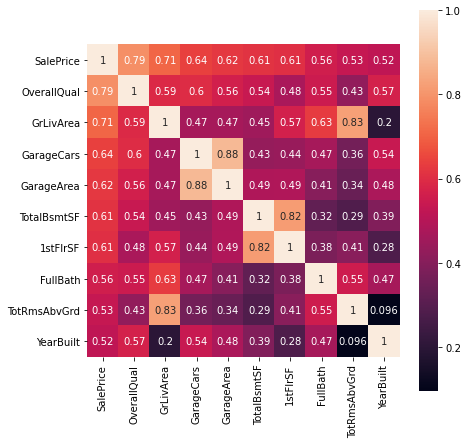

In [25]:
k=10
corr_cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = train[corr_cols].corr()
plt.figure(figsize=(7,7))
sns.heatmap(cm,annot=True, square=True)

К главным признакам можно отнести: OverallQual, GrLivArea, GarageCars, TotalBsmtSF, FullBath, YearBuilt

Посмотрим на зависимые переменные с помощью графиков:

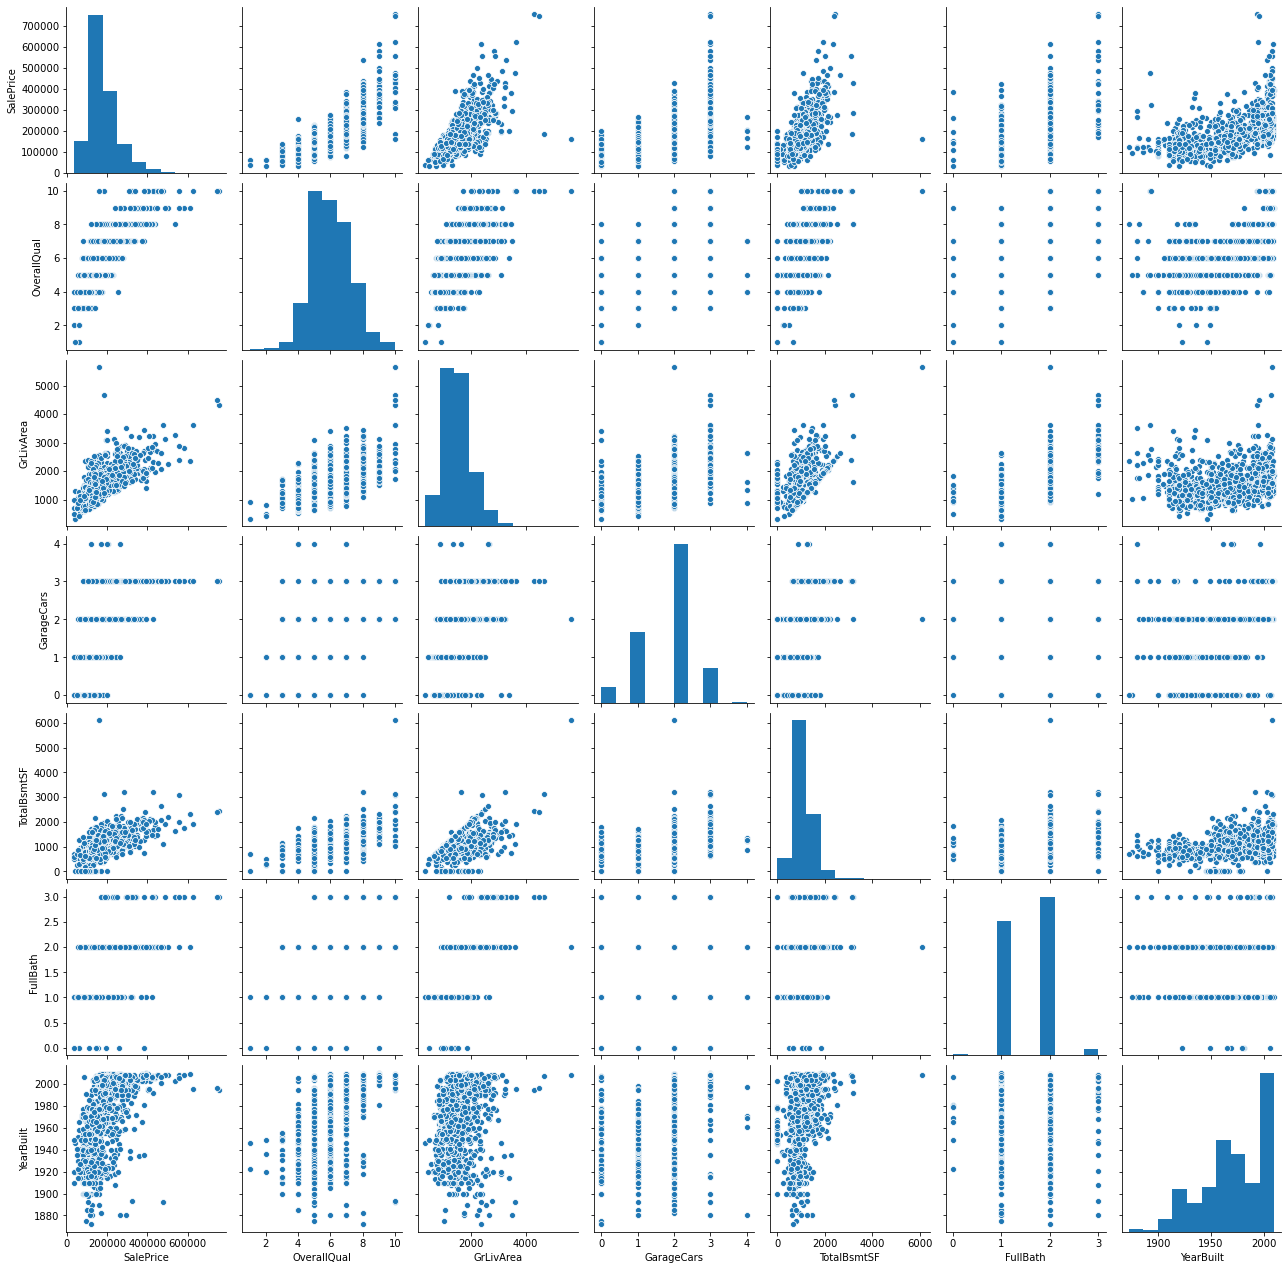

In [29]:
main_cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[main_cols])

1. Зависимость цены от OverallQual похожа на квадратичную.
2. В зависимости цены от GrLivArea есть две выбившиеся точки.
3. В зависимости SalePrice oт TotalBstmtSF есть отдна выбившиеся точка
4. Зависимость SalePrice от YearBuilt похоже на экспоненциальную
5. TotalBsmtSF ограничивает GrLivArea

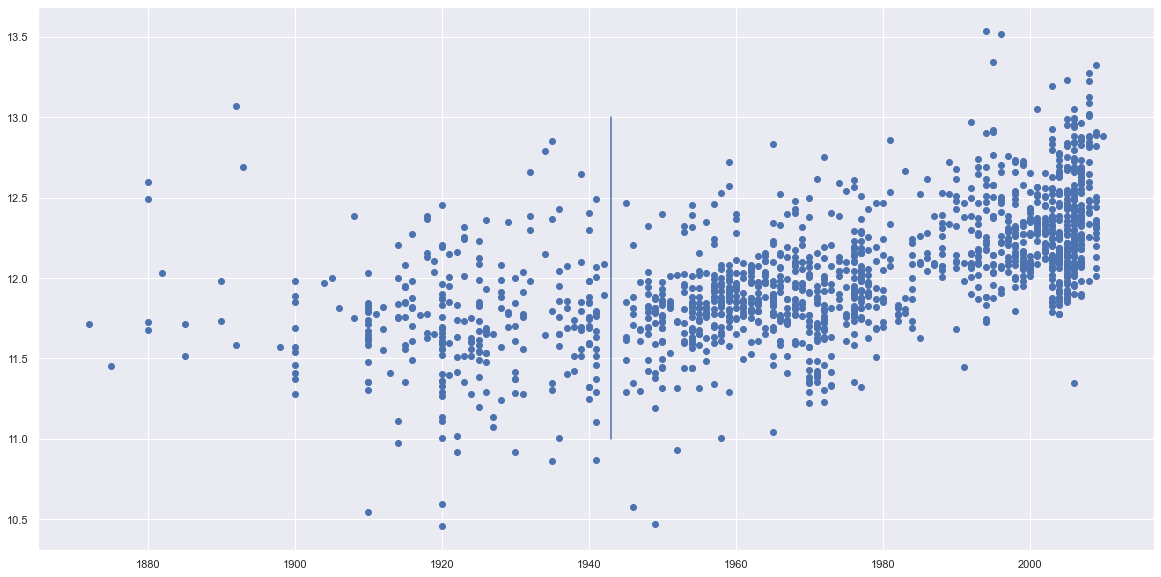

In [383]:
plt.figure(figsize=(20,10))
plt.scatter(train.YearBuilt, np.log(train.SalePrice))
plt.plot([1943, 1943], [11, 13])
plt.show()

Анализ пропусков:

In [3]:
missings = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([missings, percent], axis=1, keys=['Total', 'Percent'])[missings>0]
missing_data

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


Есть несколько признаков с количеством пропусков боле 80 процентов.
1. PoolQC. Poolcuality присутствует только в домах с бассеином. Его можно будет преобразовать и заполнить пропуски
2. MiscFeature, Alley and Host можно убрать
3. Гаражы можно объединить или оставить только GarageCars
4. Bsmt можно убрать
5. Mas можно убрать
6. Electrical: Можно удалить объект с этим пропущенным значением

In [4]:
dell_cols = missing_data.drop(['PoolQC', 'Electrical']).index
df_train = train.drop(dell_cols, axis=1)
df_train = df_train.drop(df_train[df_train.Electrical.isnull()].index, axis=0)
df_train = df_train.fillna('NA')

In [5]:
df_train.isnull().sum().sum()

0

## Категориальные признаки

In [263]:
cat_f = df_train.dtypes[df_train.dtypes == object].index

print("Количество признаков:", len(cat_f))
cat_f

Количество признаков: 29


Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'PavedDrive', 'PoolQC', 'SaleType', 'SaleCondition'],
      dtype='object')

Категориальные признаки, которе лекго перевести в числовые по описанию датасета:
1. LotShape  {'Reg':-1, 'IR1':0, 'IR2':1, 'IR3':2}
2. Utilities {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
3. LandSlope {'Gtl': 2, 'Mod':1, 'Sev':0}
4. Heating {'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
5. KitchenQual {'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
6. PoolQC {'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'NA':0}


In [264]:
df_train.LotShape = df_train.LotShape.map({'Reg':-1, 'IR1':0, 'IR2':1, 'IR3':2})
df_train.Utilities = df_train.Utilities.map({'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0})
df_train.LandSlope = df_train.LandSlope.map({'Gtl': 2, 'Mod':1, 'Sev':0})
df_train.HeatingQC = df_train.HeatingQC.map({'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0})
df_train.KitchenQual = df_train.KitchenQual.map({'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0})
df_train.PoolQC = df_train.PoolQC.map({'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'NA':0})

Попробуем пронумеровать остальные категориальные признаки по среднему значению цены

In [265]:
map_dict = {}
for col in df_train.dtypes[df_train.dtypes == object].index:
#for col in cat_f:
    map_list = list(df_train.groupby(col, dropna=True)['SalePrice'].mean().index)
    map_dict[col] = map_list
    df_train[col] = df_train[col].apply(lambda x: map_list.index(x)) 

In [267]:
features

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'FullBath',
 'YearBuilt',
 'KitchenQual',
 'HeatingQC',
 'CentralAir',
 'PoolQC',
 'Electrical']

Посмотрим теперь на корреляции категориальных признаков:

<AxesSubplot:>

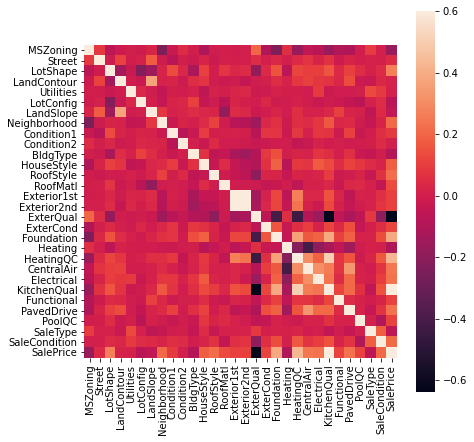

In [124]:
corr_matrix = df_train[np.concatenate([cat_f,['SalePrice']])].corr()
plt.figure(figsize=(7,7))
sns.heatmap(corr_matrix,square=True, vmax=0.6)

1. ExterQual сильно зависит от Foundation,HeatingQC, KitchenQual.
2. Exterior1st зависит от Exterior2nd

In [134]:
k=15
main_cols = np.abs(corr_matrix).nlargest(k, 'SalePrice')['SalePrice'].index

<AxesSubplot:>

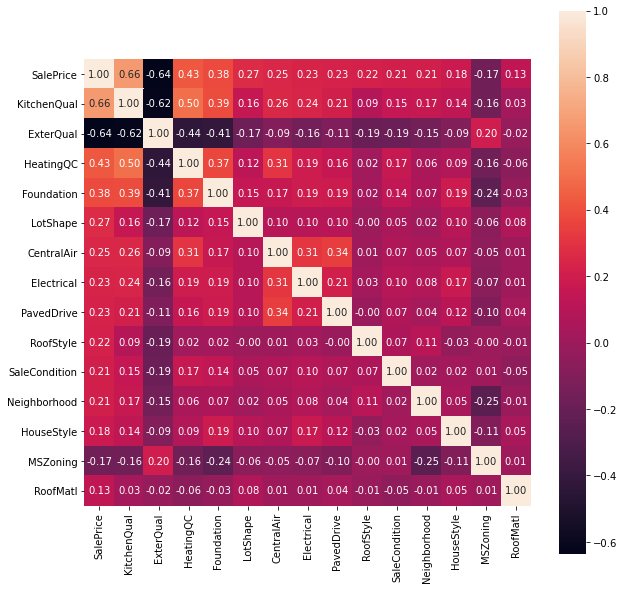

In [136]:
c_m = df_train[main_cols].corr()
plt.figure(figsize=(10,10))
sns.heatmap(c_m,square=True, annot=True, fmt='.2f')

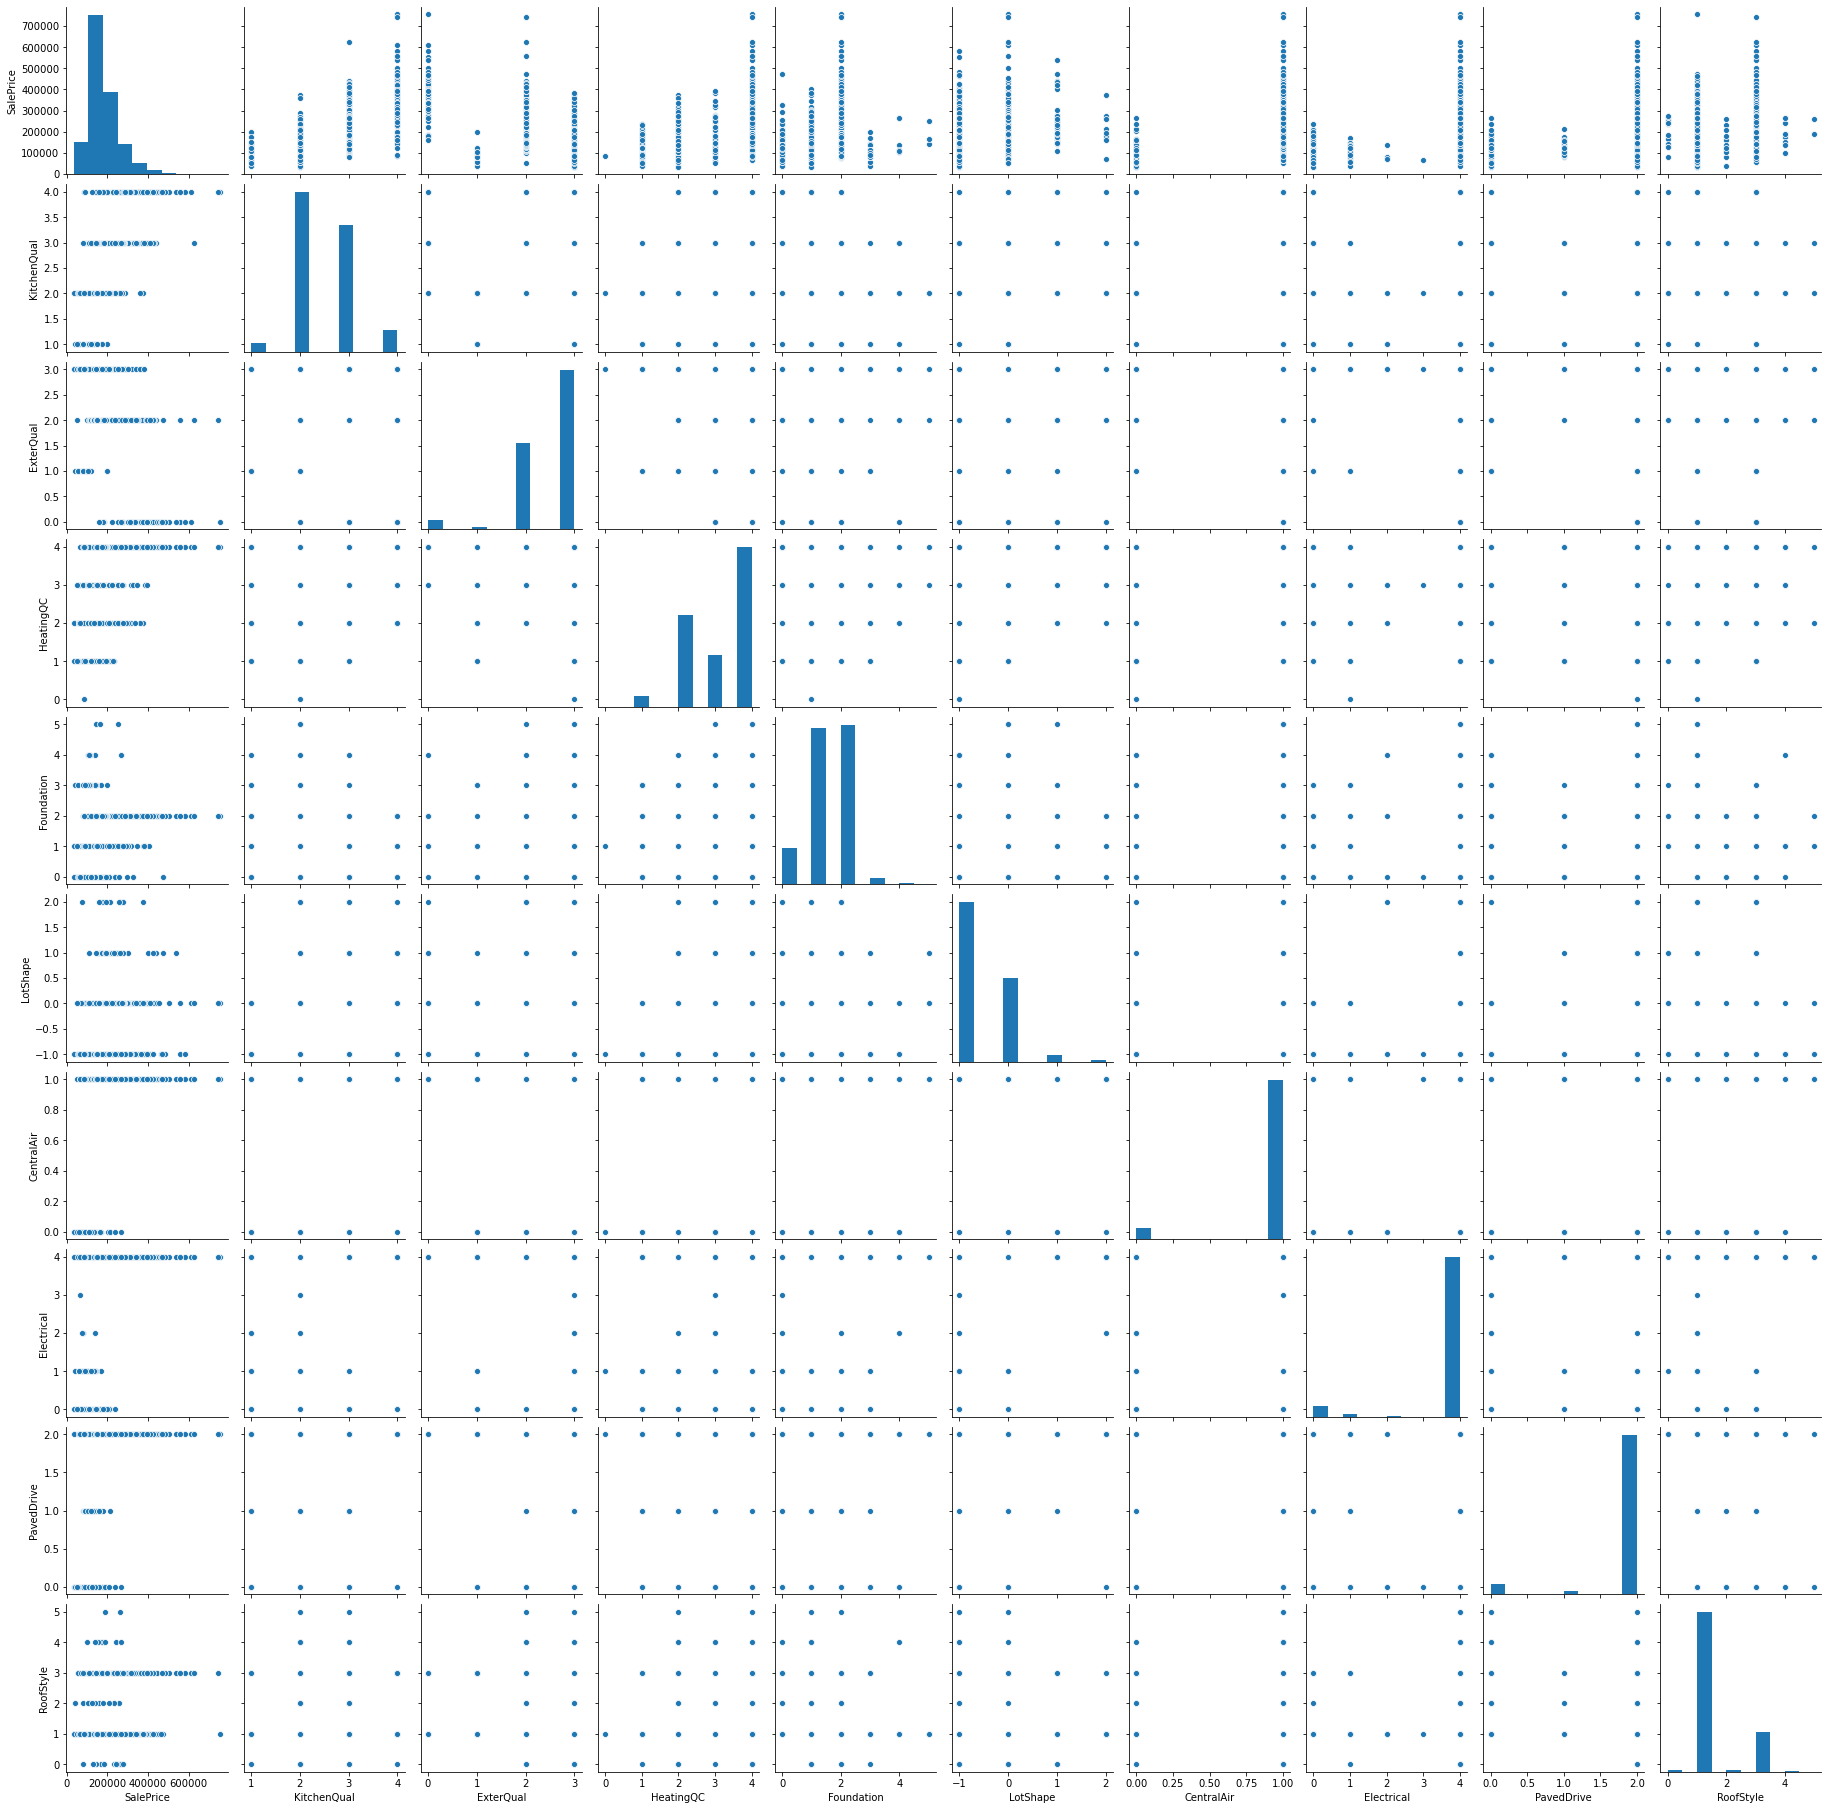

In [133]:
sns.pairplot(df_train[main_cols])

Мы можем выбрать KitchenQual, HeatingQC, CentralAir, PoolQC, Electrical

## Нормализация числовых переменных

Целевая переменная

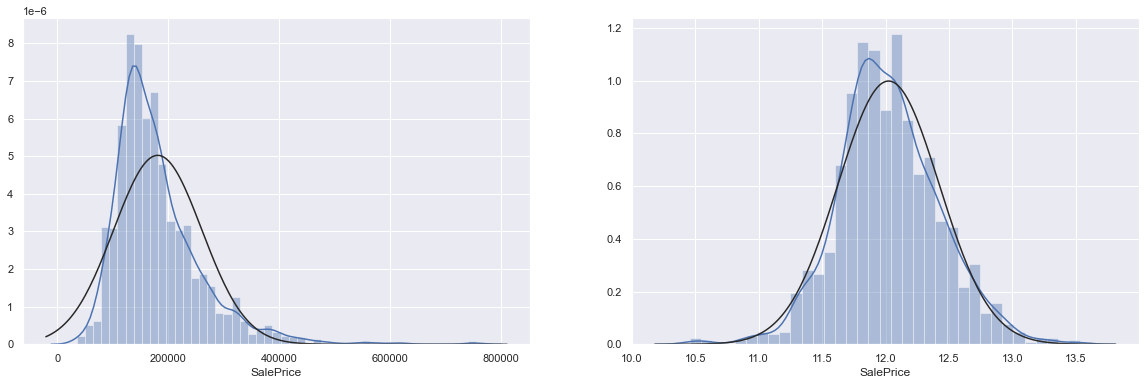

In [12]:
sns.set()
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.distplot(a=df_train.SalePrice, ax=ax[0], fit=norm)
ax[1] = sns.distplot(a=np.log(df_train.SalePrice), ax=ax[1], fit=norm)

Распределение имеет довольно длинный хвост в области высоких цен, поэтому целесообразно считать лографим от цены, так логаривмирование уменьшает скошенность распределения

GrLivArea тоже имеет скошенность, которую можно убрать логарифмированием

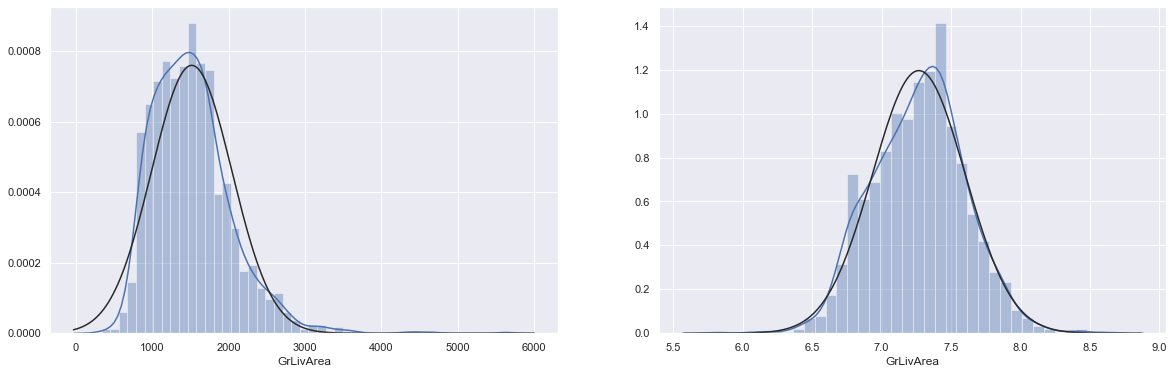

In [17]:
col = 'GrLivArea'
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.distplot(a=df_train[col], ax=ax[0], fit=norm)
ax[1] = sns.distplot(a=np.log(df_train[col]), ax=ax[1], fit=norm)

У TotalBsmtSF присутствует нули в значениях, что не позволяет на провести логарифмирование. Можно ввести отдельную переменную, которая отвечает за присутствие или отсутствие Bsmt

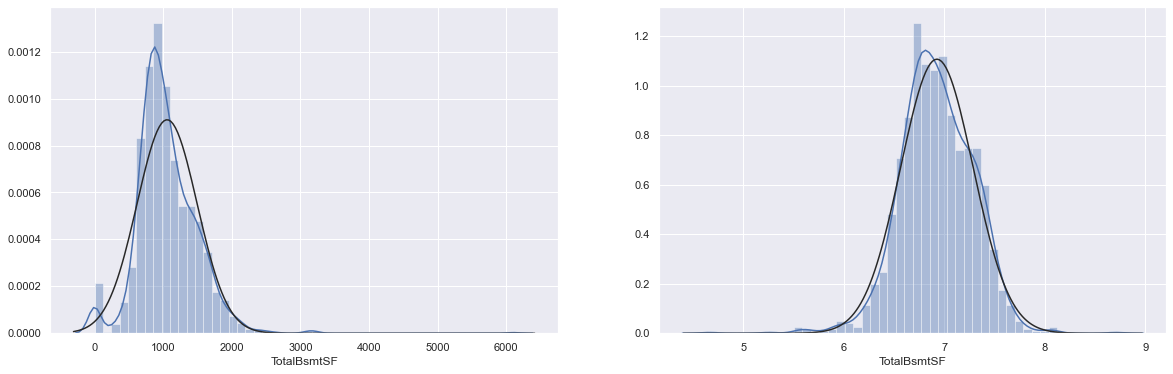

In [19]:
col = 'TotalBsmtSF'
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.distplot(a=df_train[col], ax=ax[0], fit=norm)
ax[1] = sns.distplot(a=np.log(df_train.loc[df_train[col]>0, col]), ax=ax[1], fit=norm)

## Анализ выбившихся точек

In [269]:
num_f = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
cat_f = ['KitchenQual', 'HeatingQC', 'CentralAir', 'PoolQC', 'Electrical']
features = num_f + cat_f

In [270]:
train_data = df_train[features]
features.remove('SalePrice')
test_data = test[features]
train_data.SalePrice = np.log(train_data.SalePrice)

D:\Programs\Anaconda\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


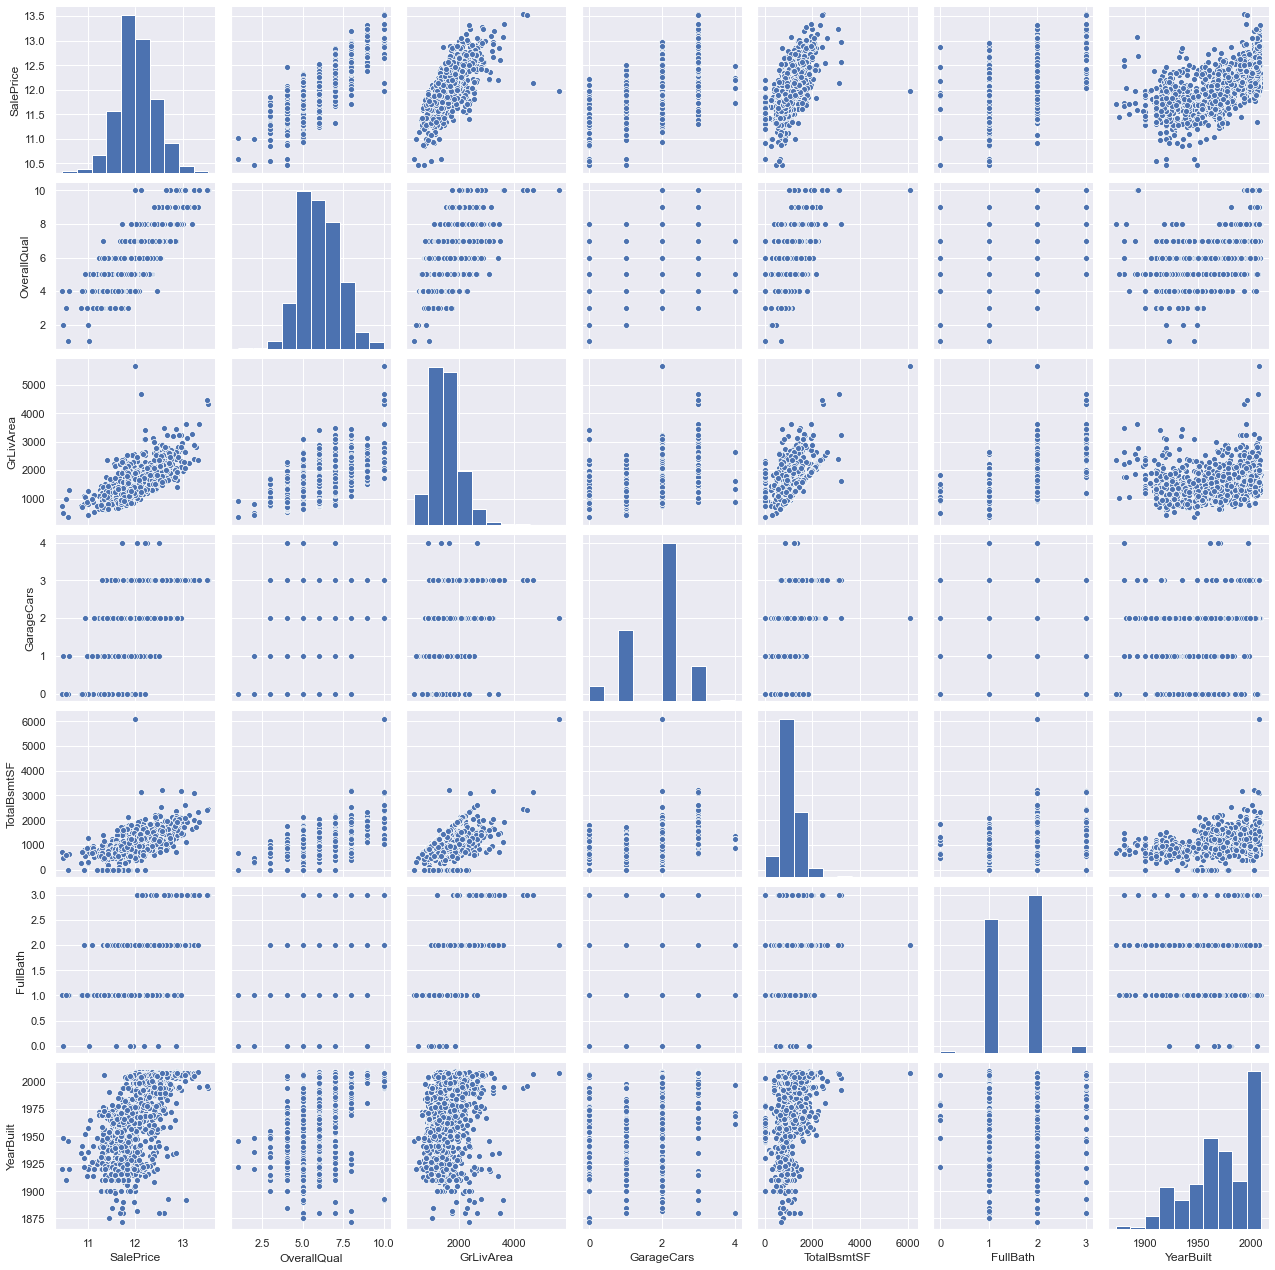

In [271]:
sns.pairplot(train_data[num_f])

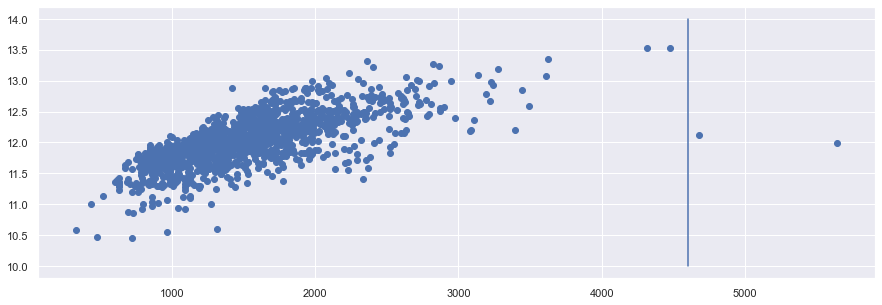

In [272]:
plt.figure(figsize=(15, 5))
plt.scatter(train_data.GrLivArea, train_data.SalePrice)
plt.plot([4600, 4600], [10, 14])

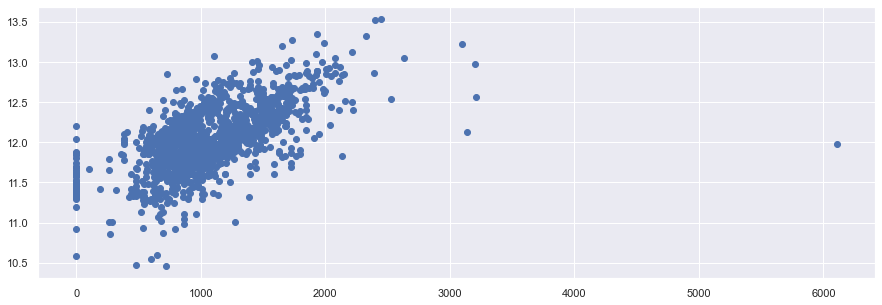

In [273]:
plt.figure(figsize=(15, 5))
plt.scatter(train_data.TotalBsmtSF, train_data.SalePrice)
#plt.plot([4600, 4600], [10, 14])

In [274]:
train_data = train_data[train_data.GrLivArea<4600]
train_data = train_data[train_data.TotalBsmtSF < 6000]

# Преобразование датасетов

## Подготовка для логистической регрессии

In [181]:
train = pd.read_csv('train.csv', index_col='Id')
test = pd.read_csv('test.csv', index_col='Id')

In [182]:
test.isnull().sum().sort_values(ascending=False)[1:18]

MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageFinish      78
GarageYrBlt       78
GarageQual        78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
dtype: int64

In [183]:
num_cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
cat_cols = list(train.dtypes[train.dtypes == 'object'].index)
#cat_cols = [x  for x in cat_cols if x not in dell_cols]
features = num_cols + cat_cols
train = train[features]
features.remove("SalePrice")
test = test[features]

In [184]:
train = train.drop(train[train.Electrical.isnull()].index)

In [185]:
train = train[train.GrLivArea<4600]
train = train[train.TotalBsmtSF < 6000]
train.SalePrice = np.log(train.SalePrice)
        
datasets = [train, test]
for i, data in enumerate(datasets):
    
    data['PoolQC']= data.PoolQC.fillna('NA')
    data['MiscFeature']= data.MiscFeature.fillna('NA')
    data['Alley']= data.Alley.fillna('NA')
    data['Fence']= data.Fence.fillna('NA')
    data['FireplaceQu']= data.FireplaceQu.fillna('NA')
    data['GarageCond']= data.GarageCond.fillna('NA')
    data['GarageQual']= data.GarageQual.fillna('NA')
    data['GarageFinish']= data.GarageFinish.fillna('NA')
    data['GarageType']= data.GarageType.fillna('NA')
    data['BsmtCond']= data.BsmtCond.fillna('NA')
    data['BsmtExposure']= data.BsmtExposure.fillna('NA')
    data['BsmtQual']= data.BsmtQual.fillna('NA')
    data['BsmtFinType1']= data.BsmtFinType1.fillna('NA')
    data['MasVnrType']= data.BsmtFinType1.fillna('None')
    data.LotShape = data.LotShape.map({'Reg':-1, 'IR1':0, 'IR2':1, 'IR3':2})
    data.Utilities = data.Utilities.map({'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0})
    data.LandSlope = data.LandSlope.map({'Gtl': 2, 'Mod':1, 'Sev':0})
    data.HeatingQC = data.HeatingQC.map({'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0})
    data.KitchenQual = data.KitchenQual.map({'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0})
    data.PoolQC = data.PoolQC.map({'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'NA':0})





    data['GarageCars']= data.GarageCars.fillna(0)
    data['TotalBsmtSF']= data.TotalBsmtSF.fillna(0)

    data['Utilities'] = data.Utilities.fillna(data.Utilities.median())
    data['KitchenQual'] = data.KitchenQual.fillna(data.Utilities.median())

    data['YearBuilt'] = data['YearBuilt'].apply(lambda x: 1941 if x < 1943 else x)
    #data['YearBuilt2'] = (data['YearBuilt']/1943)**2
    data['OverallQual2'] = data['OverallQual']**2 

    data['GrLivArea'] = np.log(data['GrLivArea'])
    data['IsBsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x>0 else 0)
    data['TotalBsmtSF'] = data['TotalBsmtSF'].apply(lambda x: np.log(x) if x > 0 else 0)
    

In [186]:
all_data = pd.concat((train, test))

In [187]:
all_dum_data = pd.get_dummies(all_data)

In [188]:
X = all_dum_data[:len(train)].drop('SalePrice', axis=1)
y = all_dum_data[:len(train)]["SalePrice"]
X_final = all_dum_data[len(train):].drop('SalePrice', axis=1)

In [189]:
X.shape, y.shape

((1457, 259), (1457,))

In [190]:
X_final.isnull().sum().sort_values(ascending=False).head(11)

SaleCondition_Partial    0
Condition1_RRAn          0
RoofMatl_CompShg         0
RoofStyle_Shed           0
RoofStyle_Mansard        0
RoofStyle_Hip            0
RoofStyle_Gambrel        0
RoofStyle_Gable          0
RoofStyle_Flat           0
HouseStyle_SLvl          0
HouseStyle_SFoyer        0
dtype: int64

In [164]:
X_final.Utilities

Id
1461    3.0
1462    3.0
1463    3.0
1464    3.0
1465    3.0
       ... 
2915    3.0
2916    3.0
2917    3.0
2918    3.0
2919    3.0
Name: Utilities, Length: 1459, dtype: float64

### Преобразование тестовой выборки для случайного леса

In [484]:
test_data.HeatingQC = test_data.HeatingQC.map({'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0})
test_data.KitchenQual = test_data.KitchenQual.map({'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0})
test_data.PoolQC = test_data.PoolQC.map({'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'NA':0})

NameError: name 'test_data' is not defined

In [277]:
for col in ['CentralAir', 'Electrical']:
    map_list = map_dict[col]
    test_data[col] = test_data[col].apply(lambda x: map_list.index(x) if x in map_list else float('nan')) 

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [278]:
test_data.isnull().sum()

OverallQual       0
GrLivArea         0
GarageCars        1
TotalBsmtSF       1
FullBath          0
YearBuilt         0
KitchenQual       1
HeatingQC         0
CentralAir        0
PoolQC         1456
Electrical        0
dtype: int64

In [279]:
test_data = test_data.fillna(train_data[train_data.OverallQual == 5].median())

In [280]:
test_data.loc[1556]

OverallQual       5.0
GrLivArea      1224.0
GarageCars        1.0
TotalBsmtSF     689.0
FullBath          1.0
YearBuilt      1917.0
KitchenQual       2.0
HeatingQC         3.0
CentralAir        0.0
PoolQC            0.0
Electrical        4.0
Name: 1556, dtype: float64

# Обучение моделей

## Линейная регрессия

In [12]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

#### Lasso

In [191]:
def scorer(estimator, X, y):
    return -(mse(estimator.predict(X), y))*0.5

In [192]:
grid = {
    'alpha':[0.0005, 0.001, 0.1, 0.2, 0.3],
    'max_iter': [100, 500, 1000, 2000],
    'normalize': [True, False]
}

In [193]:
GS = GridSearchCV(Lasso(), grid, scoring=scorer)

In [194]:
GS.fit(X, y)

D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0787372165168101, tolerance: 0.018911575852744757
  positive)
D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06161879150362992, tolerance: 0.017997180045467576
  positive)
D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06337366234232178, tolerance: 0.018377523137079594
  positive)
D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.0005, 0.001, 0.1, 0.2, 0.3],
                         'max_iter': [100, 500, 1000, 2000],
                         'normalize': [True, False]},
             scoring=<function scorer at 0x000002798E09F3A8>)

In [195]:
GS.best_params_

{'alpha': 0.0005, 'max_iter': 500, 'normalize': False}

In [196]:
GS.best_score_

-0.007572505262703392

In [197]:
best_lr = GS.best_estimator_
best_lr.fit(X, y)

Lasso(alpha=0.0005, max_iter=500)

In [198]:
results1 = np.exp(best_lr.predict(X_final))

### Ridge

In [199]:
grid = {
    'alpha':[0.001, 0.1, 0.2, 0.3, 0.4],
    'max_iter': [50, 100, 200, 400, 500, 1000],
    'normalize': [True, False],
    'tol': [1e-3, 1e-4, 1e-5]
}

In [200]:
GS = GridSearchCV(Ridge(), grid, scoring=scorer)

In [201]:
GS.fit(X, y)
print(GS.best_params_)
print(GS.best_score_)

{'alpha': 0.4, 'max_iter': 50, 'normalize': False, 'tol': 0.001}
-0.008693152767039658


In [202]:
best_r = GS.best_estimator_
best_r.fit(X, y)
results2 = np.exp(best_lr.predict(X_final))

## Случайный лес

In [104]:
X = train_data.drop('SalePrice',axis=1)
y = train_data.SalePrice

NameError: name 'train_data' is not defined

In [117]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

In [203]:
rf = RFR(n_estimators = 1000, n_jobs = -1, oob_score=True, max_features = 'sqrt')

In [106]:
rf.fit(X_train, y_train)

print((mse(rf.predict(X_test), y_test))*0.5)

NameError: name 'X_train' is not defined

In [204]:
rf.fit(X, y)
print((mse(rf.predict(X), y))*0.5)

0.001475374804775387


In [357]:
cross_val_score(rf, X, y, scoring=scorer)

array([-0.00955045, -0.01453062, -0.01312285, -0.00983347, -0.01219199])

In [205]:
results3 = np.exp(rf.predict(X_final))

In [194]:
datasets[0].median()

PoolQC               3.0
ExterQual            3.0
KitchenQual          3.0
BsmtQual             2.0
Condition2           2.0
RoofMatl             1.0
FireplaceQu          4.0
Neighborhood        12.0
BsmtCond             3.0
MiscFeature          4.0
OverallQual          6.0
GrLivArea         1464.0
GarageCars           2.0
GarageArea         480.0
TotalBsmtSF        991.5
1stFlrSF          1087.0
FullBath             2.0
TotRmsAbvGrd         6.0
YearBuilt         1973.0
YearRemodAdd      1994.0
SalePrice       163000.0
dtype: float64

In [ ]:
datasets[0].median()

In [ ]:
for data in datasets:

# Сохранение результатов

In [110]:
def create_answer(results, name):
    idx = list(pd.read_csv('test.csv').Id)
    my_results = pd.DataFrame({'Id': idx, 'SalePrice':results})
    my_results.to_csv(name, index=False)

In [206]:
create_answer(np.mean([results1, results2, results3], axis=0), 'answer9.txt')

In [112]:
np.mean([results1, results2, results3], axis=0).shape

(1459,)